# Fast Structure Learning

This notebook demonstrates the basic fast structure learning features to reproduce the "dove" experiment from the Pixels to planning paper (https://arxiv.org/abs/2407.20292).

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import jax
import jax.numpy as jnp
import pymdp
from rgm.fast_structure_learning import *

import mediapy
import matplotlib.pyplot as plt

Load the data and fit an RGM

In [12]:
path_to_file = "../data/dove.mp4"

frames = read_frames_from_mp4(path_to_file)

generations

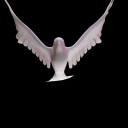

In [13]:
ims = [frames[i] for i in range(frames.shape[0])]
with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"generations": ims}, width=320, height=320, fps=10, codec="gif")

Map pixels of the video to discrete sequence of observations using patch-wise dimensionality reduction (SVD)

In [14]:
(observations, locations_matrix, group_indices, sv_discrete_axis, Vs_padded_and_stacked, V_per_patch_dimensions), patch_indices, patch_centroids, patch_weights, valid_counts = map_rgb_2_discrete(frames, tile_diameter=32, n_bins=9, sv_thr=0.0, max_n_modes=12)

Run fast structure learning on the sequence of observations

In [15]:
#agents, RG, LB = spm_mb_structure_learning(observations, locations_matrix, max_levels=8)

Another use-case is when you do structure learning on 'batches' of data. Here, we fit structure learning on the first 16 timesteps, and then run it again on the final 20 timesteps (last four of the first sequence, and then all 16 of the second half of the sequence), using the previous agents and group partitions estimated in the first run

In [16]:
agents, RG, LB = spm_mb_structure_learning(observations[:,:16,:], locations_matrix, max_levels=8)

structure learn level 0 group 0 time 0.06772422790527344
structure learn level 0 group 1 time 0.06116771697998047
structure learn level 0 group 2 time 0.06050682067871094
structure learn level 0 group 3 time 0.06104159355163574
structure learn level 1 group 0 time 0.0324854850769043


In [17]:
agents, RG, _ = spm_mb_structure_learning(observations[:,12:,:], locations_matrix, max_levels=8, agents=agents, RG=RG)

structure learn level 0 group 0 time 0.04522991180419922
structure learn level 0 group 1 time 0.04275178909301758
structure learn level 0 group 2 time 0.04215121269226074
structure learn level 0 group 3 time 0.04283595085144043
structure learn level 1 group 0 time 0.022877216339111328


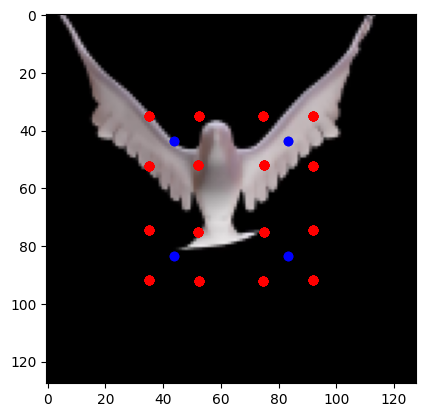

In [18]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])
colors = ['r', 'b']
for (i,locations_matrix) in enumerate(LB):
    plt.scatter(locations_matrix[:,0], locations_matrix[:,1], c=colors[i])
plt.show()

Now we can generate data ... choose any one hot vector as top-level start state D.

In [19]:
one_hot = jnp.zeros([1, 8])
one_hot = one_hot.at[0, 5].set(1.0)
D = one_hot

In [20]:
from pymdp.control import compute_expected_obs
from jax import vmap
from functools import partial

expected_obs = partial(compute_expected_obs, A_dependencies=agents[-1].A_dependencies)

qo = vmap(expected_obs)([D,], agents[-1].A)

In [21]:
import jax.tree_util as jtu

expected_obs2 = partial(compute_expected_obs, A_dependencies=agents[-2].A_dependencies)

# split this in initial state "D" and path "E"
D2 = qo[::2]
for i in range(len(agents[-2].B)):
    D2[i] = D2[i][:, :agents[-2].B[i].shape[1]]
# TODO also transition using this policy matrix?
E2 = jtu.tree_map(lambda x: jnp.expand_dims(jnp.argmax(x), [0]), qo[1::2])

qs_next, _ = agents[-2].update_empirical_prior(E2, jtu.tree_map(lambda x : jnp.expand_dims(x, 0), D2))

# stack D2 and qs_next and generate qo at once
#qo2 = vmap(expected_obs2)(D2, agents[-2].A)
#qo2_nxt = vmap(expected_obs2)(qs_next, agents[-2].A)

stacked = []
for x,y in zip(D2, qs_next):
    stacked.append(jnp.concatenate([x, y], axis=0))

A_stacked = jtu.tree_map(lambda x: jnp.broadcast_to(x, (2, x.shape[1], x.shape[2])), agents[-2].A)
qo_stacked = vmap(expected_obs2)(stacked, A_stacked)


In [22]:
obs = jnp.array(qo_stacked)

# vmap over the batch dimension
#img = map_discrete_2_rgb(obs[:, 0, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])
#img2 = map_discrete_2_rgb(obs[:, 1, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])

# map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
# imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = map_discrete_2_rgb(obs, sv_discrete_axis, patch_indices, Vs_padded_and_stacked, V_per_patch_dimensions, valid_counts, image_shape=frames.shape[-3:])
imgs = imgs.reshape((4, imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

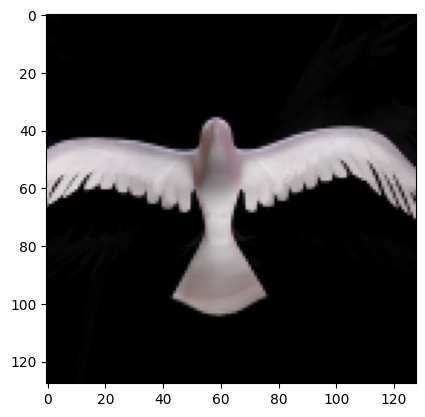

In [23]:
import numpy as onp

def to_img(img):
    im = jnp.transpose(img, (1, 2, 0))
    im /= 255
    im = jnp.clip(im, 0, 1)
    im = (255*im).astype(onp.uint8)
    return im

plt.imshow(to_img(imgs[0]))


predictions

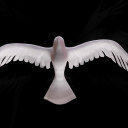

In [24]:
import mediapy

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"predictions": ims}, fps=1, codec='gif')


generations

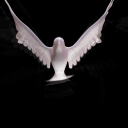

In [25]:
# generate n step predictions
one_hot = jnp.zeros([1, 8])
one_hot = one_hot.at[0, 0].set(1.0)
D = [one_hot]
E = jnp.array([[0]])
observations, beliefs = predict(agents, D, E, num_steps=32)

# convert to images
obs = jnp.array(observations[0])
# map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, locations_matrix=locations_matrix, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
# imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = map_discrete_2_rgb(obs, sv_discrete_axis, patch_indices, Vs_padded_and_stacked, V_per_patch_dimensions, valid_counts, image_shape=frames.shape[-3:])

imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"generations": ims}, width=320, height=320, fps=10, codec='gif')